In [1]:
import os
import sys
# SRC_DIR environment variable should be the absolute path to the 'multicopy-STR-genotyping' directory
sys.path.append(os.environ["SRC_DIR"])

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from multicopy_STR_genotyping import file_io

sns.set_context("poster")
%matplotlib inline

In [3]:
df_in_segdup = pd.read_csv("../../data/hg38_ver13_0boe_mononucleotides_in_segdup.bed", sep="\t", names=["chr", "start", "end", "period", "unit"])
df_in_segdup = df_in_segdup.assign(str_id = lambda x: [f"{i}_{j + 1}" for i, j in zip(x["chr"], x["start"])])

df_constrain = pd.read_csv("../../results/HG002/2024-04-07_hg002_ConSTRain0.7.0.csv").rename(columns={"match": "constrain_match"})
df_constrain = df_constrain[~df_constrain["str_id"].isin(df_in_segdup["str_id"])].reset_index(drop=True)

df_gangstr = pd.read_csv("../../results/HG002/2024-03-19_hg002_str_length_calls_gangstr.csv").rename(columns={"match": "gangstr_match"}).drop(["haplo_region_len", "softmatch"], axis=1)
df_gangstr = df_gangstr[~df_gangstr["str_id"].isin(df_in_segdup["str_id"])].reset_index(drop=True)

print(df_constrain.shape, df_gangstr.shape)

(1603475, 7) (1588412, 3)


In [4]:
df_constrain.head()

,str_id,haplo_region_len,estimated_region_len,constrain_match,copy_number,depth,period
0,chr1_899025,"[22, 22]","[22, 22]",True,2,8,1
1,chr1_902774,"[14, 14]","[14, 14]",True,2,59,1
2,chr1_904440,"[9, 9]","[9, 9]",True,2,55,3
3,chr1_904654,"[12, 12]","[12, 12]",True,2,48,3
4,chr1_907237,"[14, 14]","[14, 14]",True,2,49,1


In [5]:
(
    df_constrain
        .query("period <= 6")
        .filter(["period", "constrain_match"], axis=1)
        .groupby("period", as_index=False)
        .agg(accuracy=("constrain_match", lambda x: x.sum() / x.shape[0]))
)

,period,accuracy
0,1,0.917353
1,2,0.940190
2,3,0.985261
3,4,0.989891
4,5,0.983814
5,6,0.988877


In [6]:
(
    df_gangstr
        .merge(df_constrain.filter(["period", "str_id"], axis=1), on="str_id", how="inner")
        .query("period <= 6")
        .filter(["period", "gangstr_match"], axis=1)
        .groupby("period", as_index=False)
        .agg(accuracy=("gangstr_match", lambda x: x.sum() / x.shape[0]))
)

,period,accuracy
0,1,0.934387
1,2,0.926389
2,3,0.981707
3,4,0.986683
4,5,0.984073
5,6,0.988953


In [7]:
df_str_calls = df_constrain.merge(df_gangstr, on="str_id", how="inner")
df_str_calls

,str_id,haplo_region_len,estimated_region_len,constrain_match,copy_number,depth,period,gangstr_region_len,gangstr_match
0,chr1_899025,"[22, 22]","[22, 22]",True,2,8,1,"[22, 22]",True
1,chr1_902774,"[14, 14]","[14, 14]",True,2,59,1,"[14, 14]",True
2,chr1_904440,"[9, 9]","[9, 9]",True,2,55,3,"[9, 9]",True
3,chr1_904654,"[12, 12]","[12, 12]",True,2,48,3,"[12, 12]",True
4,chr1_907237,"[14, 14]","[14, 14]",True,2,49,1,"[14, 14]",True
...,...,...,...,...,...,...,...,...,...
1581001,chrY_26487819,[10],[10],True,1,31,1,[10],True
1581002,chrY_26487987,[10],[10],True,1,38,1,[10],True
1581003,chrY_26489202,[12],[12],True,1,33,4,[12],True
1581004,chrY_26489935,[12],[12],True,1,23,3,[12],True


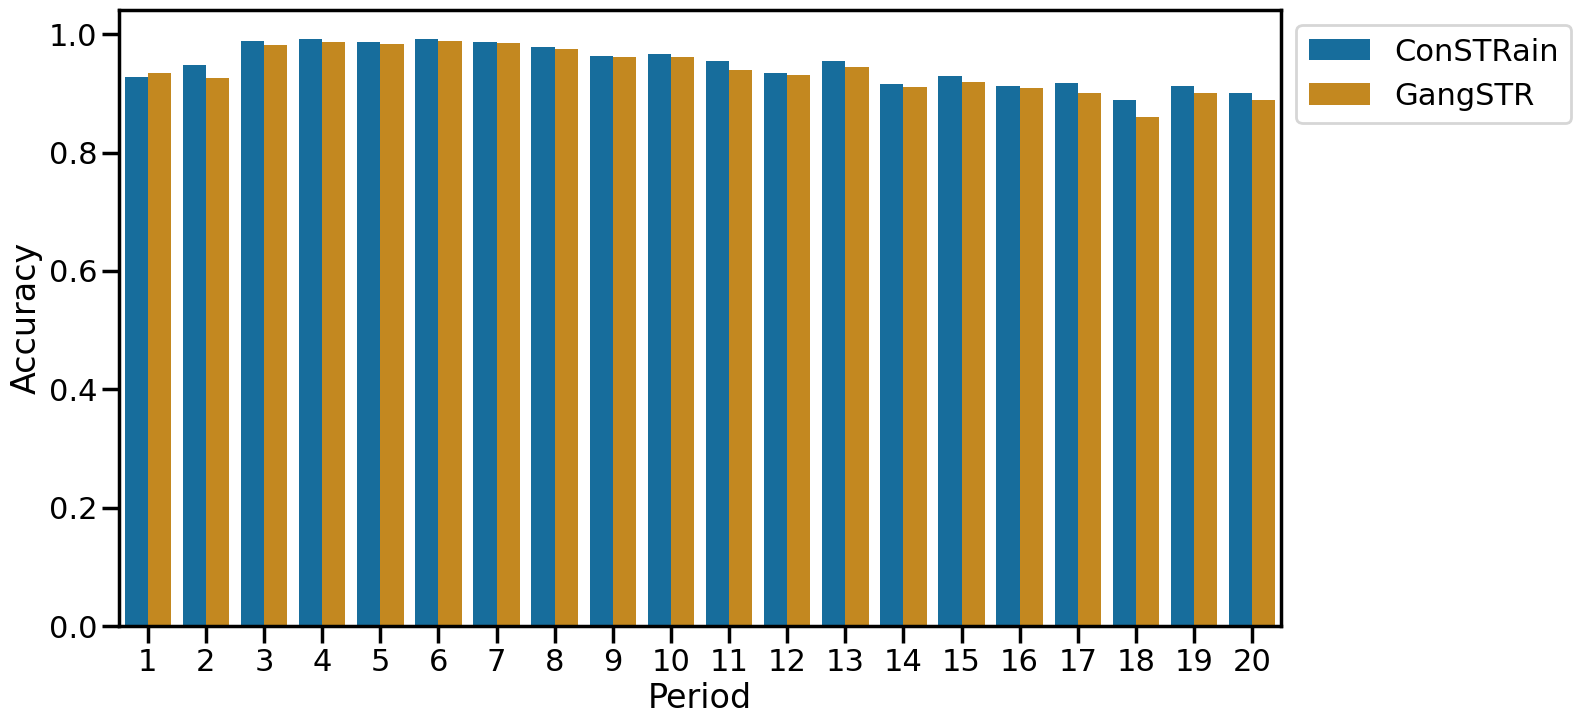

In [8]:
df_overview = (df_str_calls[["period", "gangstr_match", "constrain_match"]]
               .groupby("period", as_index=False)
               .agg(ConSTRain = ("constrain_match", lambda x: x.sum() / len(x)), 
                    GangSTR = ("gangstr_match", lambda x: x.sum() / len(x)))
               .melt(id_vars="period", var_name="approach", value_name="accuracy"))

fig = plt.figure(figsize=(15, 8))

ax = sns.barplot(
    data=df_overview,
    x="period",
    y="accuracy",
    hue="approach",
    palette="colorblind",
)

ax.set(
    xlabel="Period",
    # xlim=(None, 6),
    ylabel="Accuracy",    
)
ax.get_legend().set(bbox_to_anchor=(1,1), title="")

plt.show()

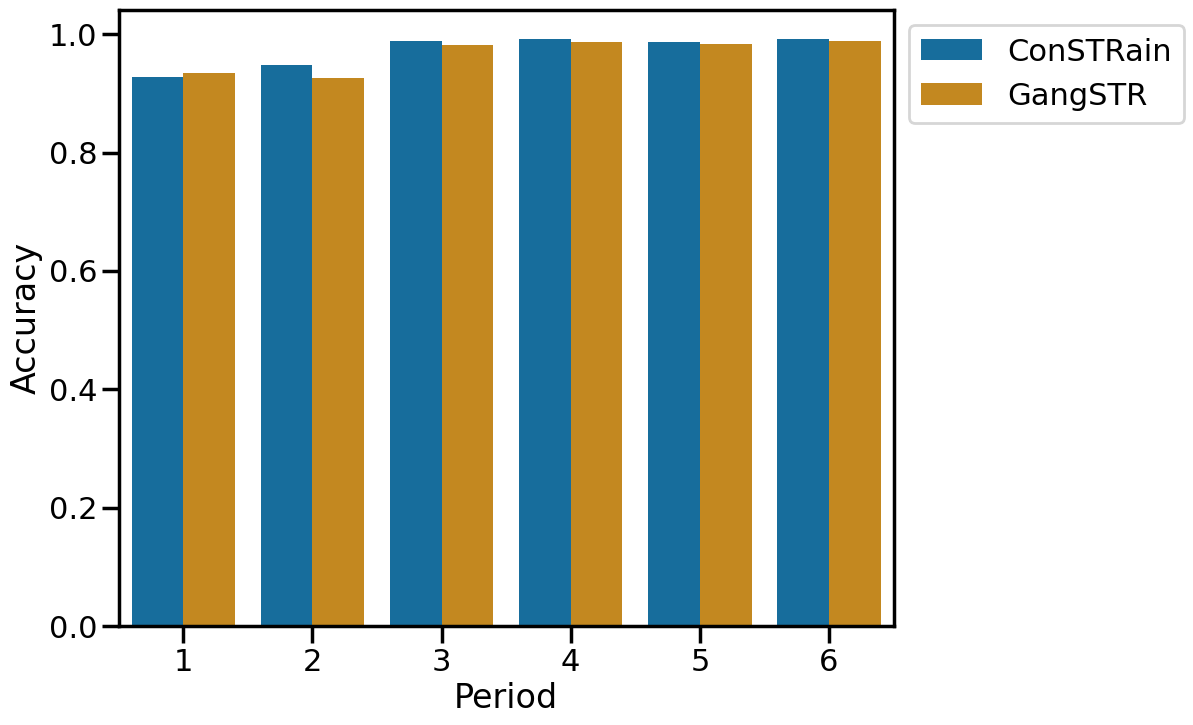

In [9]:
df_overview = (df_str_calls[["period", "gangstr_match", "constrain_match"]]
               .query("period < 7")
               .groupby("period", as_index=False)
               .agg(ConSTRain = ("constrain_match", lambda x: x.sum() / len(x)), 
                    GangSTR = ("gangstr_match", lambda x: x.sum() / len(x)))
               .melt(id_vars="period", var_name="approach", value_name="accuracy"))

fig = plt.figure(figsize=(10, 8))

ax = sns.barplot(
    data=df_overview,
    x="period",
    y="accuracy",
    hue="approach",
    palette="colorblind",
)

ax.set(
    xlabel="Period",
    # xlim=(None, 6),
    ylabel="Accuracy",    
)
ax.get_legend().set(bbox_to_anchor=(1,1), title="")

plt.show()

In [10]:
print(
    df_str_calls["constrain_match"].sum() / df_str_calls.shape[0],
    df_str_calls["gangstr_match"].sum() / df_str_calls.shape[0],
)

print(df_str_calls.query("constrain_match and gangstr_match").shape)

print(df_str_calls.query("not constrain_match and not gangstr_match").shape)

print(df_str_calls.query("constrain_match and not gangstr_match").shape)

print(df_str_calls.query("not constrain_match and gangstr_match").shape)

0.9548123157027867 0.954675693830384
(1478501, 9)
(40595, 9)
(31063, 9)
(30847, 9)


In [11]:
df_plot = pd.DataFrame(
    np.concatenate([np.repeat([1, 2, 3, 4, 5, 6], 7).reshape(-1, 1), np.tile([1, 5, 5, 10, 10, 15, 15, 20, 20, 25, 25, 30, 30, 1e6], 6).reshape(-1, 2)], axis=1),
    columns=["period", "depth_lower", "depth_upper"]
)

constrain_accuracy = []
gangstr_accuracy = []
n = []
for row in df_plot.to_dict(orient="records"):
    selected_loci = (
        df_str_calls
            .assign(depth = lambda x: x["depth"] / x["copy_number"])
            .query(f"depth >= {row['depth_lower']} and depth < {row['depth_upper']} and period == {row['period']}")["str_id"]
    )
    df_str_calls_filt = df_str_calls.loc[df_str_calls["str_id"].isin(selected_loci)]
    n.append(df_str_calls_filt.shape[0])
    constrain_accuracy.append((1 - (df_str_calls_filt.loc[~df_str_calls_filt["constrain_match"]].shape[0] / df_str_calls_filt.shape[0])) * 100)
    gangstr_accuracy.append((1 - (df_str_calls_filt.loc[~df_str_calls_filt["gangstr_match"]].shape[0] / df_str_calls_filt.shape[0])) * 100)    

df_plot["n"] = n
df_plot["constrain_accuracy"] = constrain_accuracy
df_plot["gangstr_accuracy"] = gangstr_accuracy
df_plot["depth"] = np.tile(["1-5", "5-10", "10-15", "15-20", "20-25", "25-30", "30-"], 6)

df_plot

,period,depth_lower,depth_upper,n,constrain_accuracy,gangstr_accuracy,depth
0,1.0,1.0,5.0,49004,57.529998,61.182761,1-5
1,1.0,5.0,10.0,76299,76.672040,83.655094,5-10
2,1.0,10.0,15.0,77611,87.589388,91.834920,10-15
3,1.0,15.0,20.0,86466,94.184998,94.945990,15-20
4,1.0,20.0,25.0,111959,97.709876,96.799721,20-25
5,1.0,25.0,30.0,148338,99.108118,97.745015,25-30
6,1.0,30.0,1000000.0,261989,99.550744,98.424361,30-
7,2.0,1.0,5.0,939,31.309904,26.304579,1-5
8,2.0,5.0,10.0,2577,57.043073,51.571595,5-10
9,2.0,10.0,15.0,4840,73.512397,70.103306,10-15


In [12]:
for name, data in df_plot.groupby("depth"):
    print(name, np.average(data["constrain_accuracy"], weights=data["n"]), np.average(data["gangstr_accuracy"], weights=data["n"]), data["n"].sum())
print()
for name, data in df_plot.groupby("period"):
    print(name, np.average(data["constrain_accuracy"], weights=data["n"]), np.average(data["gangstr_accuracy"], weights=data["n"]), data["n"].sum())

1-5 56.94059347531119 60.324857923819636 50853
10-15 86.02783132797093 89.34498880985618 90258
15-20 93.13817186912702 93.23082840184964 114401
20-25 97.74788583509513 96.64693446088795 189200
25-30 99.26410592424092 98.22995994461478 323552
30- 99.71927421154653 99.06237586656542 712439
5-10 75.82079718897552 82.0931395873748 81963

1.0 92.81293044183198 93.438680442448 811666
2.0 94.77331691658239 92.67138648256453 113705
3.0 98.78677860978746 98.19075712881023 132210
4.0 99.14801259946331 98.67755386332755 321601
5.0 98.73275787713723 98.42357733826076 150721
6.0 99.12706406617221 98.91646064157739 32763


[None, None]

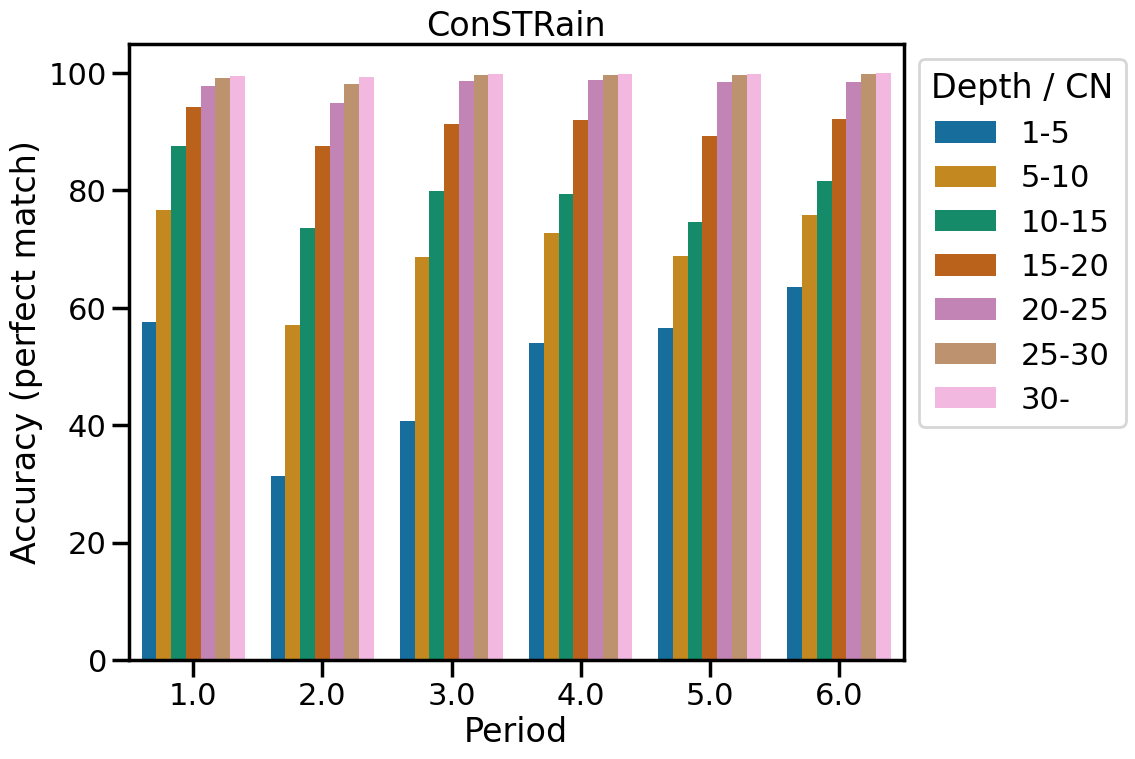

In [13]:
fig = plt.figure(figsize=(10, 8))

ax = sns.barplot(
    df_plot,
    x="period",
    y="constrain_accuracy",
    hue="depth",
    palette="colorblind"
)

ax.set(
    title="ConSTRain",
    xlabel="Period",
    ylabel = "Accuracy (perfect match)"
)

ax.get_legend().set(
    title="Depth / CN",
    bbox_to_anchor = (1, 1)
)

[None, None]

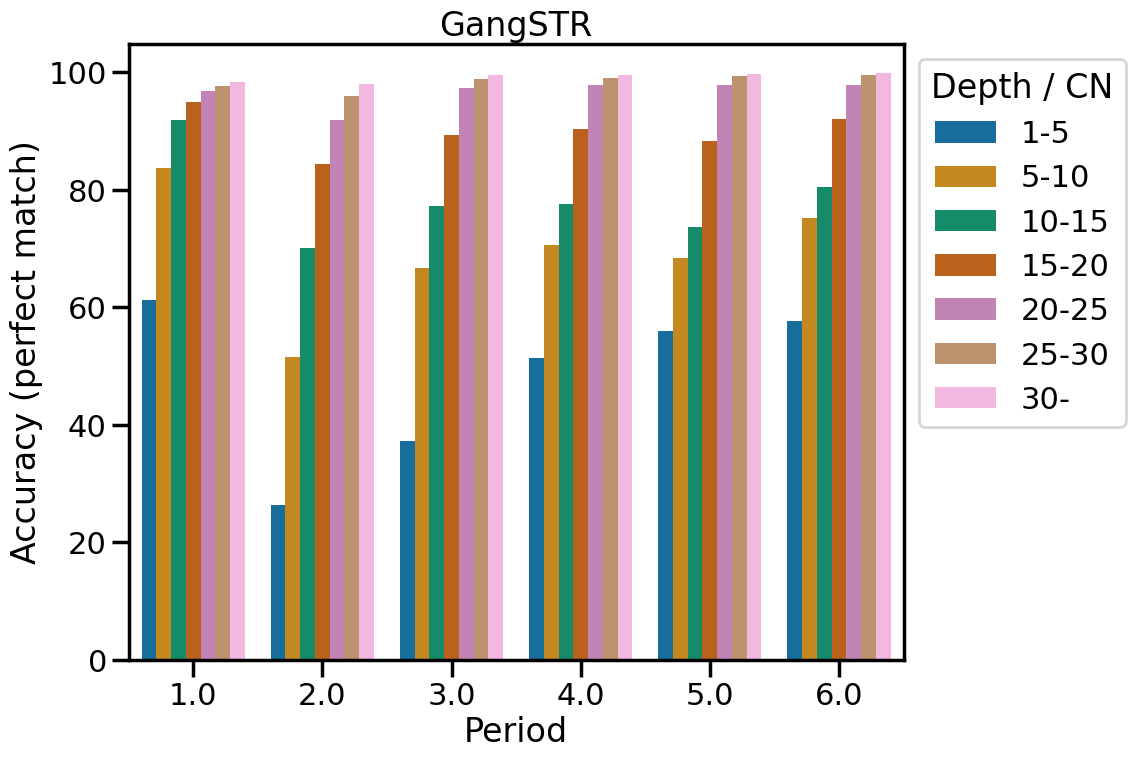

In [14]:
fig = plt.figure(figsize=(10, 8))

ax = sns.barplot(
    df_plot,
    x="period",
    y="gangstr_accuracy",
    hue="depth",
    palette="colorblind"
)

ax.set(
    title="GangSTR",
    xlabel="Period",
    ylabel = "Accuracy (perfect match)"
)

ax.get_legend().set(
    title="Depth / CN",
    bbox_to_anchor = (1, 1)
)

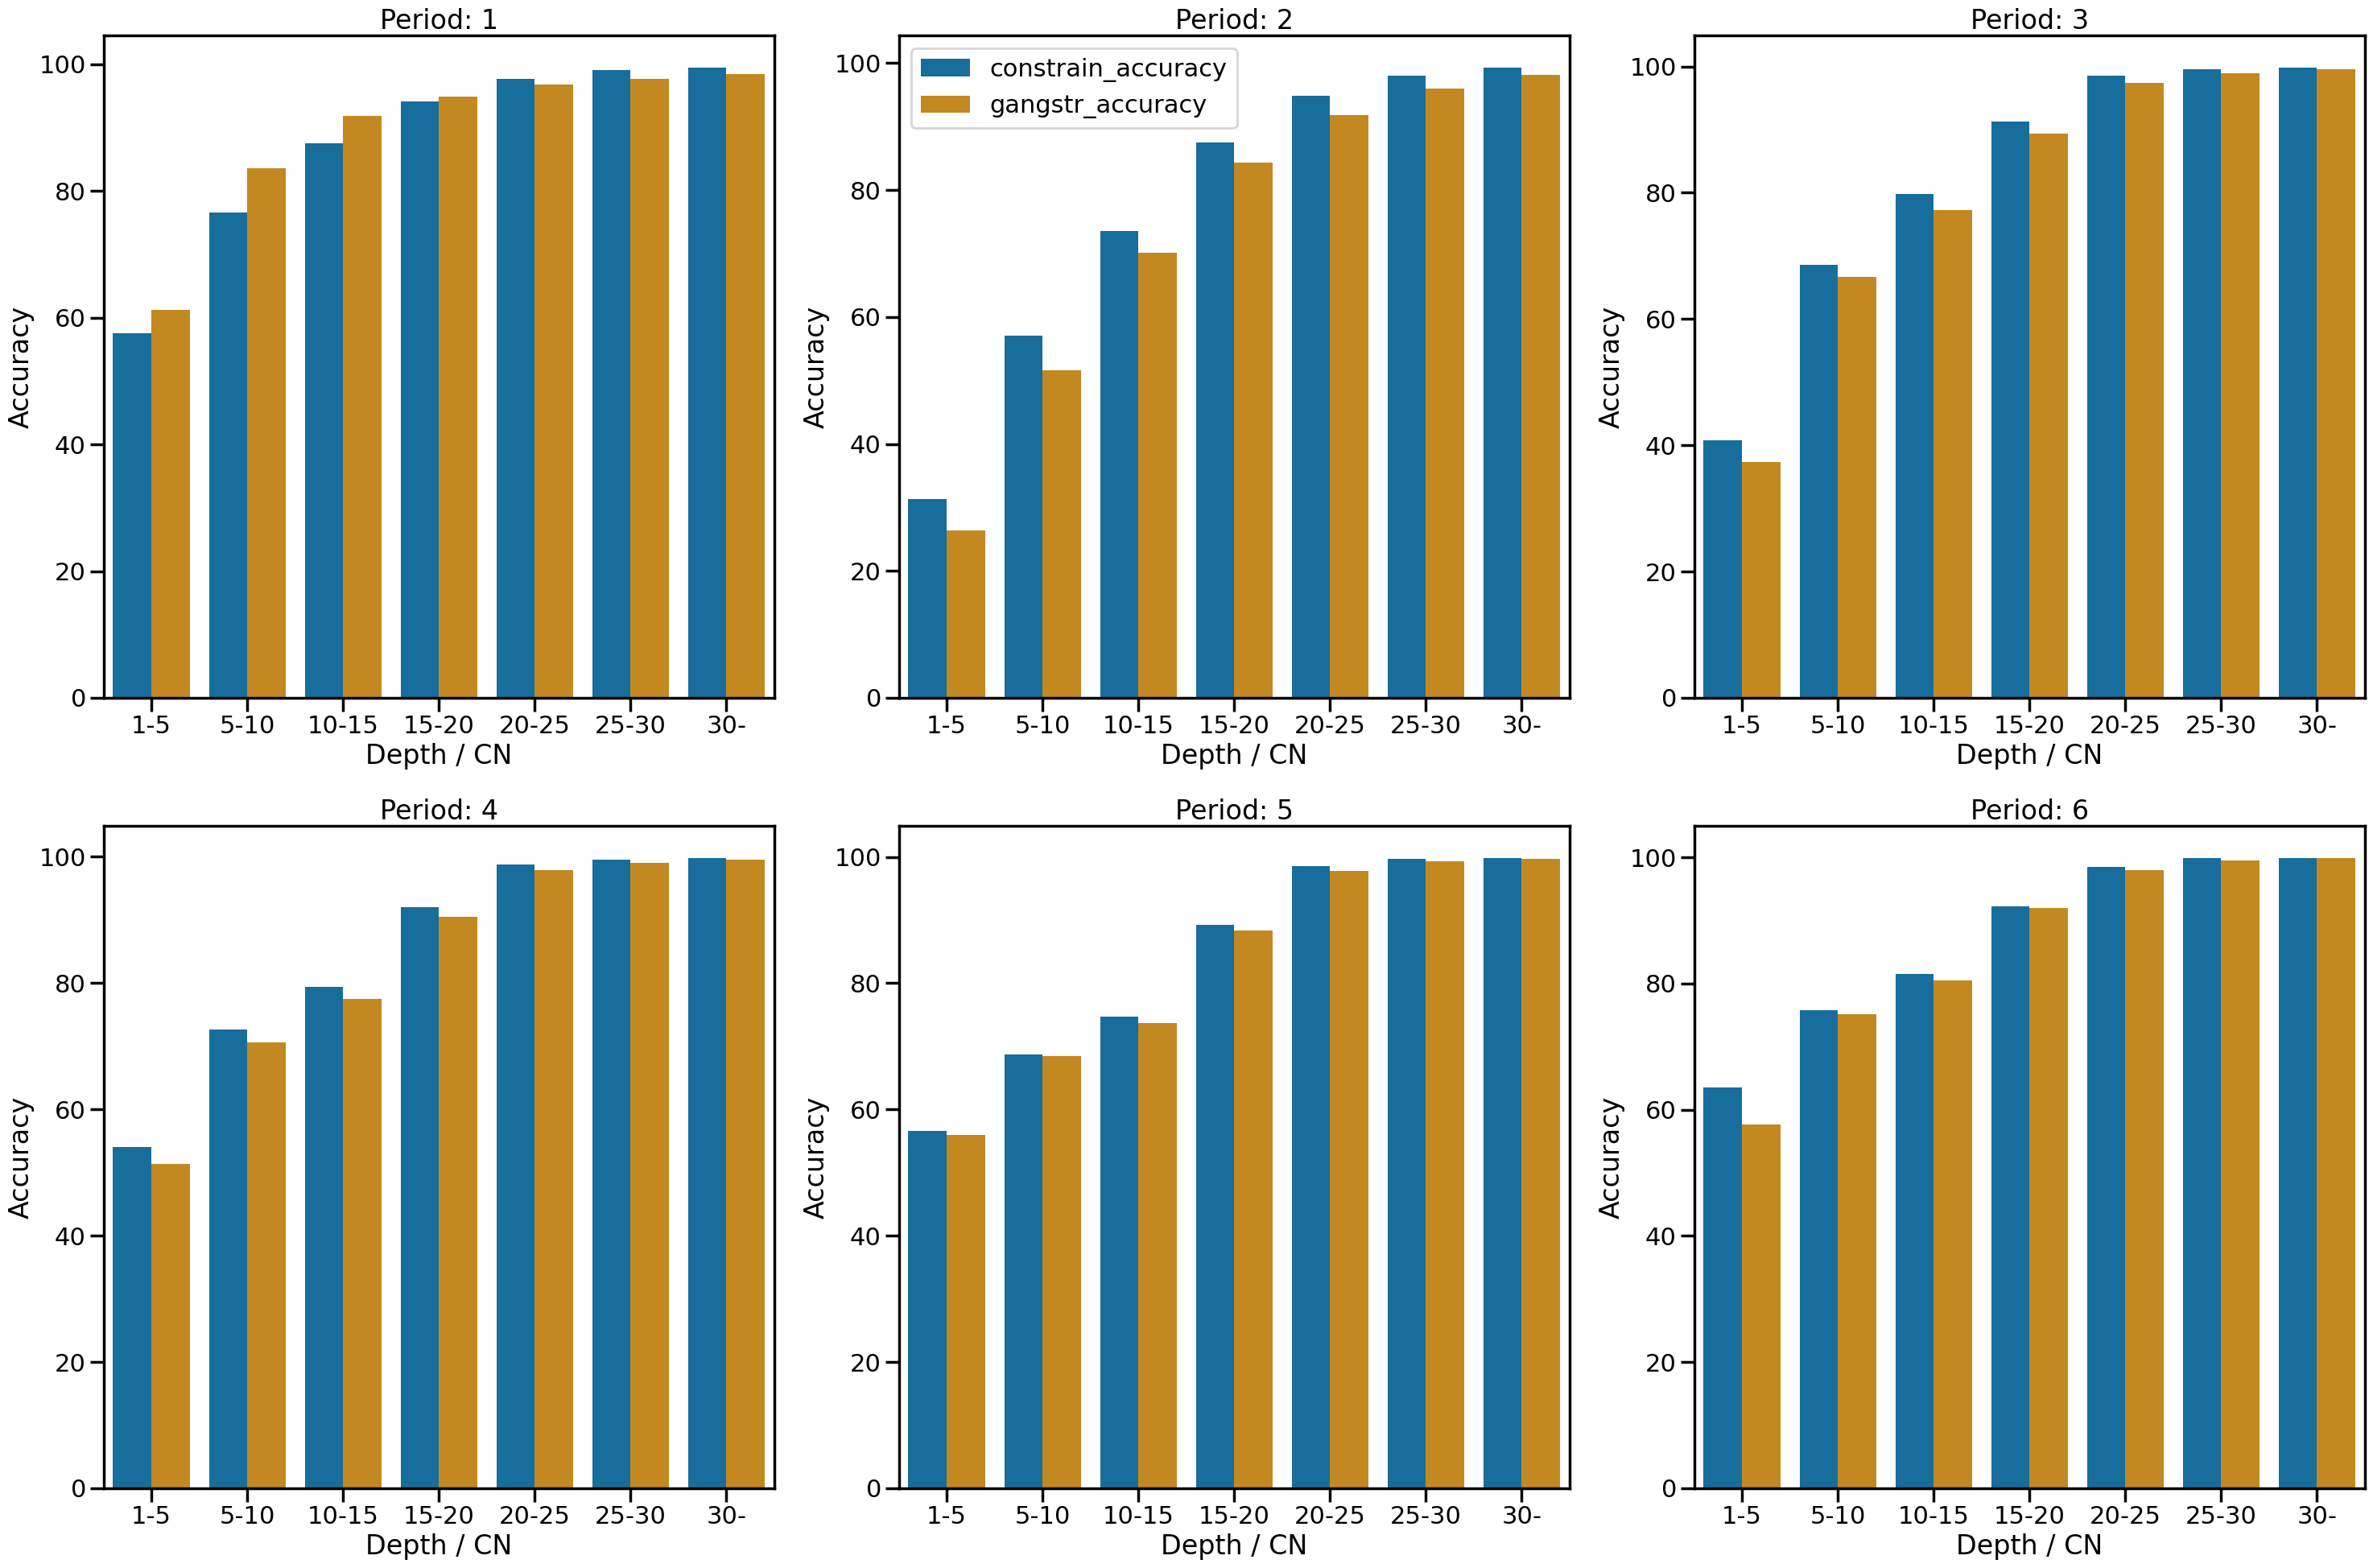

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(30, 20))

for period, ax in zip(range(1, 7), axes.ravel()):
    df_subplot = (df_plot
                  .query(f"period == {period}")[["constrain_accuracy", "gangstr_accuracy", "depth"]]
                  .melt(id_vars="depth",var_name="approach", value_name="accuracy"))
    
    ax = sns.barplot(
        data=df_subplot,
        x="depth",
        y="accuracy",
        hue="approach",
        palette="colorblind",
        ax = ax,
        legend = period == 2
    )
    if period == 2:
        # ax.get_legend().set(bbox_to_anchor = (1,1), title="")
        ax.get_legend().set(title="")
    ax.set(
        title = f"Period: {period}",
        xlabel = "Depth / CN",
        ylabel = "Accuracy"
    )

plt.tight_layout()

In [16]:
from scipy import ndimage

df_plot_density = (
    df_str_calls
        .query("period >= 1 and period <= 6")
        .assign(depth = lambda x: x["depth"] / x["copy_number"])[["constrain_match", "period", "depth"]]
)

df_plot_constrain = (
    df_plot_density        
        .drop("period", axis=1)
        .groupby(["depth"], observed=True, as_index=False).agg(
            accuracy = ("constrain_match", lambda x: x.sum() / len(x)), 
            n_obs=("constrain_match", "count"))
        # .query(f"n_obs >= {min_obs}")
        
)

smooth = []
smooth = ndimage.gaussian_filter1d(df_plot_constrain["accuracy"], 3, mode="reflect")
# for group, data in df_plot_cn_period.groupby(["period"]):
#     current_smooth = ndimage.gaussian_filter1d(data["accuracy"], 3, mode="reflect")
#     smooth.append(current_smooth)
df_plot_constrain = df_plot_constrain.assign(smooth = smooth)


df_plot_constrain_period = (
    df_plot_density
        .groupby(["period", "depth"], observed=True, as_index=False).agg(
            accuracy = ("constrain_match", lambda x: x.sum() / len(x)), 
            n_obs=("constrain_match", "count"))
        # .query(f"n_obs >= {min_obs}")
        
)

smooth = []
for group, data in df_plot_constrain_period.groupby(["period"]):
    current_smooth = ndimage.gaussian_filter1d(data["accuracy"], 3, mode="reflect")
    smooth.append(current_smooth)
df_plot_constrain_period = df_plot_constrain_period.assign(smooth = np.concatenate(smooth))

df_plot_constrain_period

,period,depth,accuracy,n_obs,smooth
0,1,1.0,0.361760,2568,0.481596
1,1,1.5,0.429790,4807,0.493136
2,1,2.0,0.547458,4446,0.514320
3,1,2.5,0.512428,6920,0.542007
4,1,3.0,0.609787,7214,0.572777
...,...,...,...,...,...
844,6,70.5,1.000000,1,1.000000
845,6,72.0,1.000000,1,1.000000
846,6,75.0,1.000000,1,1.000000
847,6,77.0,1.000000,1,1.000000


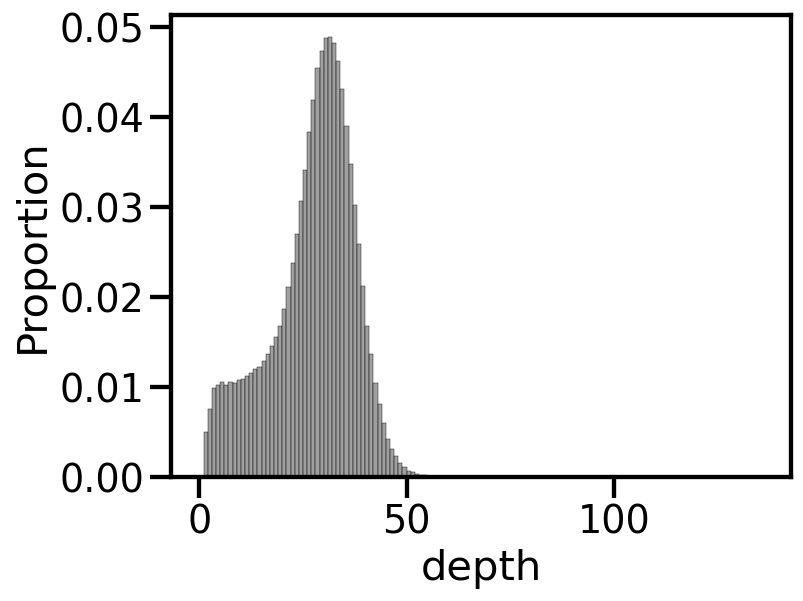

In [17]:
fig = plt.figure(dpi=125)

ax = sns.histplot(
    df_plot_density,
    x = "depth",
    discrete=True,
    stat="proportion",
    color="grey"
)

# _ = ax.set(
#     ylim=(0, 0.00001)
# )

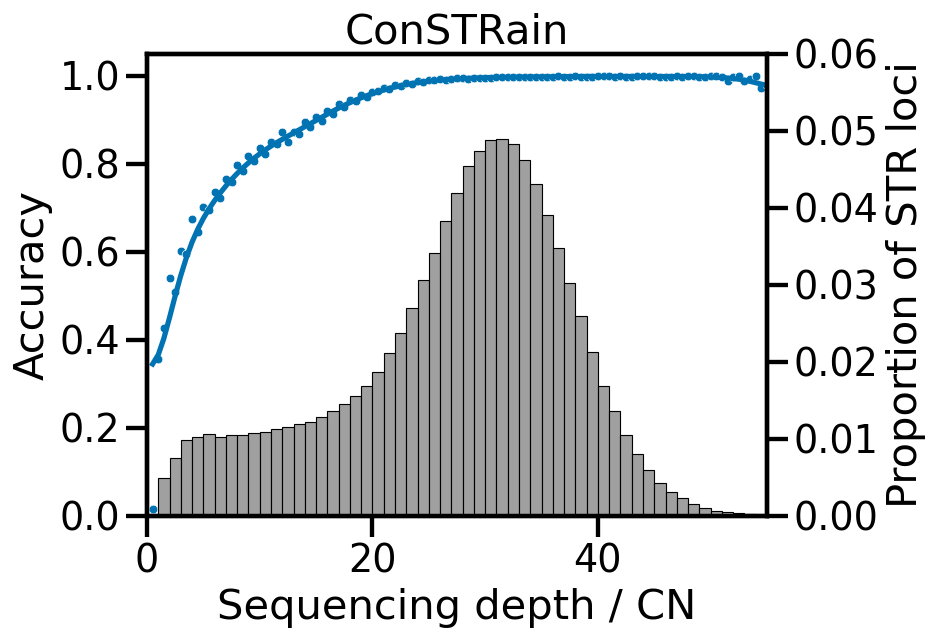

In [18]:
fig = plt.figure(dpi=125)

ax = sns.lineplot(
    df_plot_constrain,
    x = "depth",
    y = "smooth",
    color=sns.color_palette("colorblind")[0],
    # linewidth=2,
    legend=False
)

ax = sns.scatterplot(
    df_plot_constrain,
    x = "depth",
    y = "accuracy",
    color=sns.color_palette("colorblind")[0],
    s=25,
    ax = ax,
    legend=False
)

ax.set(
    title = "ConSTRain",
    xlabel = "Sequencing depth / CN",
    ylabel = "Accuracy",
    ylim = (0, 1.05),
    xlim = (0, 55)
)

ax2 = ax.twinx()
ax2 = sns.histplot(
    df_plot_density,
    x = "depth",
    discrete=True,
    stat="proportion",
    color="grey",
    ax=ax2,
)
ax2.set(
    ylabel="Proportion of STR loci",
    ylim=(0, 0.06),
)

plt.show()

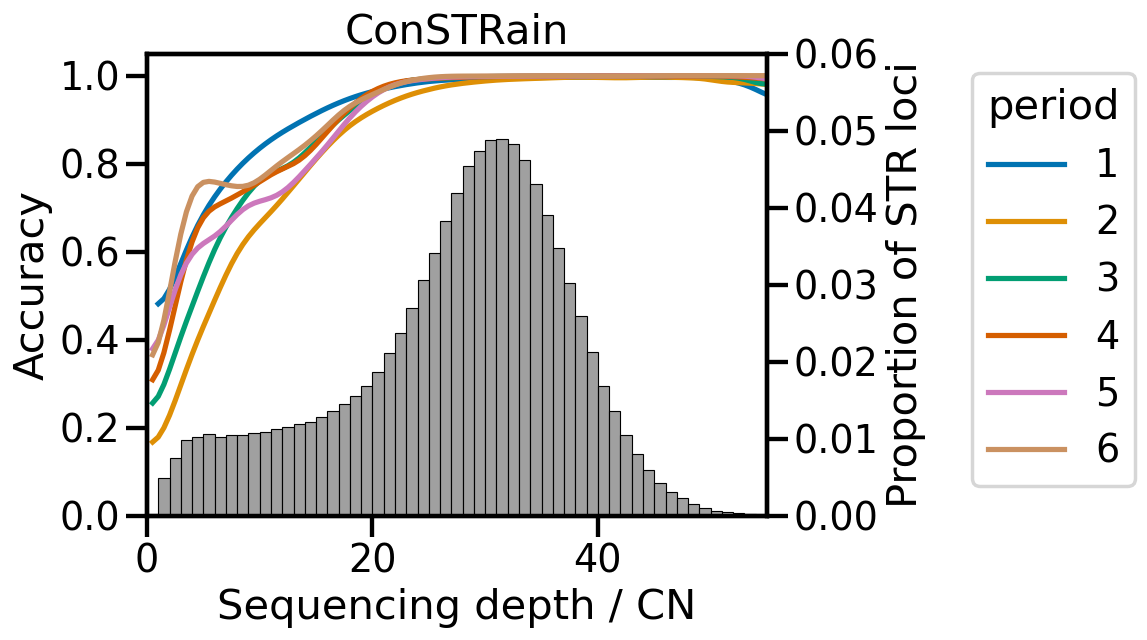

In [19]:
fig = plt.figure(dpi=125)

ax = sns.lineplot(
    df_plot_constrain_period,
    x = "depth",
    y = "smooth",
    hue="period",
    palette="colorblind",
    # linewidth=2
)

# ax = sns.scatterplot(
#     df_plot_constrain_period,
#     x = "depth",
#     y = "accuracy",
#     hue = "period",
#     palette = "colorblind",
#     s=25,
#     ax = ax,
#     legend=False
# )

ax.set(
    title = "ConSTRain",
    xlabel = "Sequencing depth / CN",
    ylabel = "Accuracy",
    ylim = (0, 1.05),
    xlim = (0, 55)
)

ax2 = ax.twinx()
ax2 = sns.histplot(
    df_plot_density,
    x = "depth",
    discrete=True,
    stat="proportion",
    color="grey",
    ax=ax2
)
ax2.set(
    ylabel="Proportion of STR loci",
    ylim=(0, 0.06),
)

ax.get_legend().set(bbox_to_anchor=(1.3, 1), loc="upper left")

plt.show()

In [20]:
from scipy import ndimage

df_plot_density = (
    df_str_calls
        .query("period >= 1 and period <= 6")
        .assign(depth = lambda x: x["depth"] / x["copy_number"])[["gangstr_match", "period", "depth"]]
)

df_plot_gangstr = (
    df_plot_density
        .drop("period", axis=1)
        .groupby(["depth"], observed=True, as_index=False).agg(
            accuracy = ("gangstr_match", lambda x: x.sum() / len(x)), 
            n_obs=("gangstr_match", "count"))
        # .query(f"n_obs >= {min_obs}")
        
)

smooth = []
smooth = ndimage.gaussian_filter1d(df_plot_gangstr["accuracy"], 3, mode="reflect")
# for group, data in df_plot_gangstr_period.groupby(["period"]):
#     current_smooth = ndimage.gaussian_filter1d(data["accuracy"], 3, mode="reflect")
#     smooth.append(current_smooth)
df_plot_gangstr = df_plot_gangstr.assign(smooth = smooth)


df_plot_gangstr_period = (
    df_plot_density
        .groupby(["period", "depth"], observed=True, as_index=False).agg(
            accuracy = ("gangstr_match", lambda x: x.sum() / len(x)), 
            n_obs=("gangstr_match", "count"))
        # .query(f"n_obs >= {min_obs}")
        
)

smooth = []
for group, data in df_plot_gangstr_period.groupby(["period"]):
    current_smooth = ndimage.gaussian_filter1d(data["accuracy"], 3, mode="reflect")
    smooth.append(current_smooth)
df_plot_gangstr_period = df_plot_gangstr_period.assign(smooth = np.concatenate(smooth))

df_plot_gangstr_period

,period,depth,accuracy,n_obs,smooth
0,1,1.0,0.446651,2568,0.518115
1,1,1.5,0.446848,4807,0.529197
2,1,2.0,0.556905,4446,0.550054
3,1,2.5,0.531792,6920,0.578385
4,1,3.0,0.629886,7214,0.611403
...,...,...,...,...,...
844,6,70.5,1.000000,1,1.000000
845,6,72.0,1.000000,1,1.000000
846,6,75.0,1.000000,1,1.000000
847,6,77.0,1.000000,1,1.000000


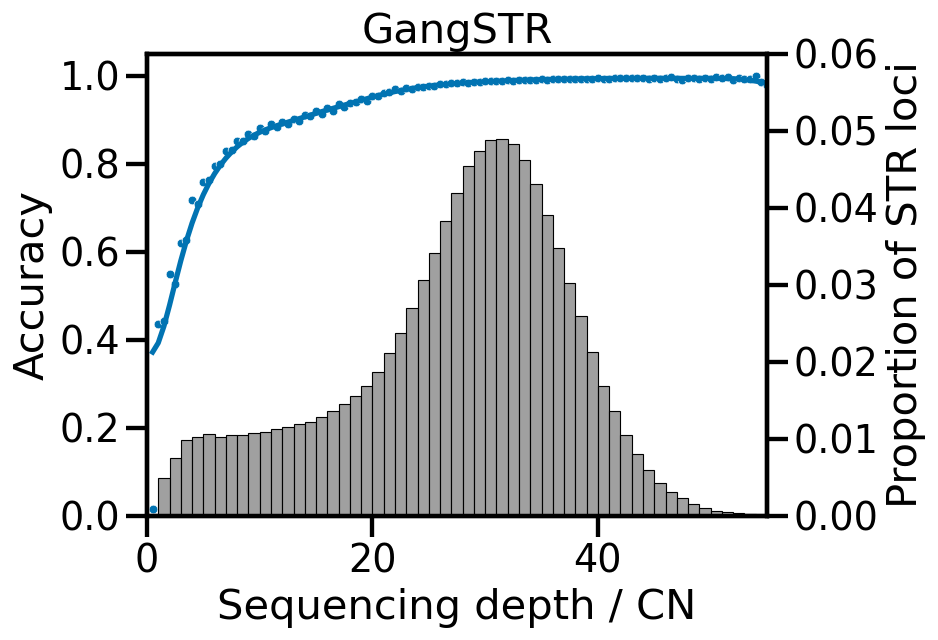

In [21]:
fig = plt.figure(dpi=125)

ax = sns.lineplot(
    df_plot_gangstr,
    x = "depth",
    y = "smooth",
    color=sns.color_palette("colorblind")[0],
    # linewidth=2,
    legend=False
)

ax = sns.scatterplot(
    df_plot_gangstr,
    x = "depth",
    y = "accuracy",
    color=sns.color_palette("colorblind")[0],
    s=25,
    ax = ax,
    legend=False
)

ax.set(
    title = "GangSTR",
    xlabel = "Sequencing depth / CN",
    ylabel = "Accuracy",
    ylim = (0, 1.05),
    xlim = (0, 55)
)

ax2 = ax.twinx()
ax2 = sns.histplot(
    df_plot_density,
    x = "depth",
    discrete=True,
    stat="proportion",
    color="grey",
    ax=ax2,
)
ax2.set(
    ylabel="Proportion of STR loci",
    ylim=(0, 0.06),
)

plt.show()

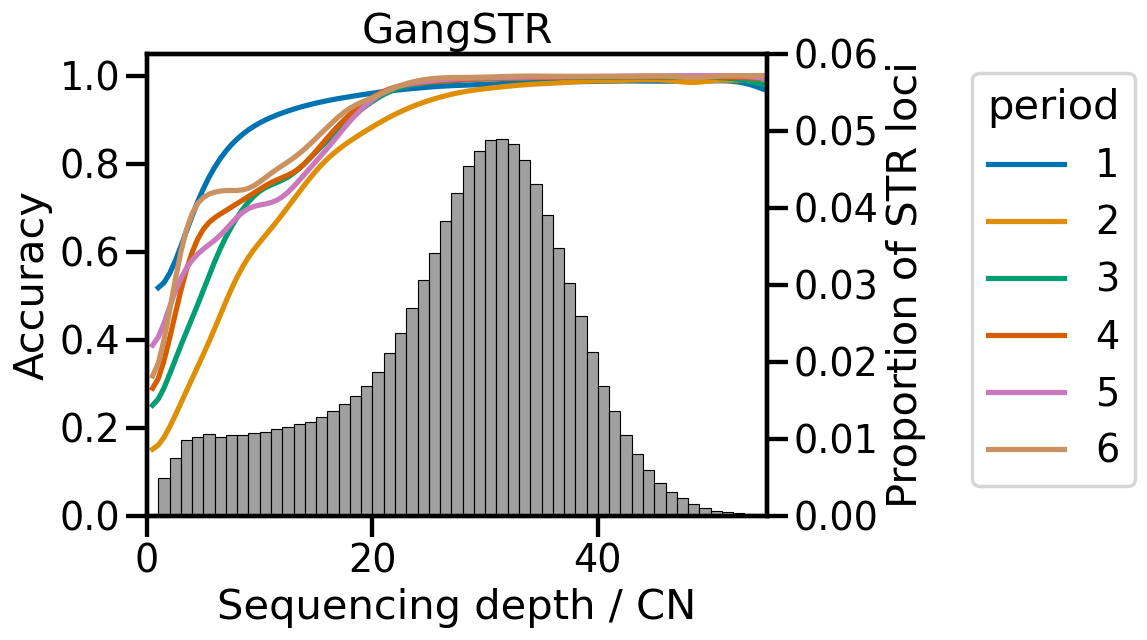

In [22]:
fig = plt.figure(dpi=125)

ax = sns.lineplot(
    df_plot_gangstr_period,
    x = "depth",
    y = "smooth",
    hue="period",
    palette="colorblind",
    # linewidth=2
)

# ax = sns.scatterplot(
#     df_plot_gangstr_period,
#     x = "depth",
#     y = "accuracy",
#     hue = "period",
#     palette = "colorblind",
#     s=25,
#     ax = ax,
#     legend=False
# )

ax.set(
    title = "GangSTR",
    xlabel = "Sequencing depth / CN",
    ylabel = "Accuracy",
    ylim = (0, 1.05),
    xlim = (0, 55)
)

ax2 = ax.twinx()
ax2 = sns.histplot(
    df_plot_density,
    x = "depth",
    discrete=True,
    stat="proportion",
    color="grey",
    ax=ax2
)
ax2.set(
    ylabel="Proportion of STR loci",
    ylim=(0, 0.06)
)

ax.get_legend().set(bbox_to_anchor=(1.3, 1), loc="upper left")

plt.show()

In [24]:
df_plot_merge = (
    df_plot_constrain.rename(columns = {"smooth": "ConSTRain"})
        .merge(
            df_plot_gangstr.rename(columns = {"smooth": "GangSTR"}), 
            on="depth")[["depth", "ConSTRain", "GangSTR"]]
        .melt(id_vars="depth", var_name="method", value_name="accuracy"))

df_plot_merge

,depth,method,accuracy
0,0.5,ConSTRain,0.344636
1,1.0,ConSTRain,0.365575
2,1.5,ConSTRain,0.403046
3,2.0,ConSTRain,0.450026
4,2.5,ConSTRain,0.499397
...,...,...,...
351,117.5,GangSTR,0.763968
352,123.0,GangSTR,0.729491
353,127.0,GangSTR,0.703811
354,131.5,GangSTR,0.687528


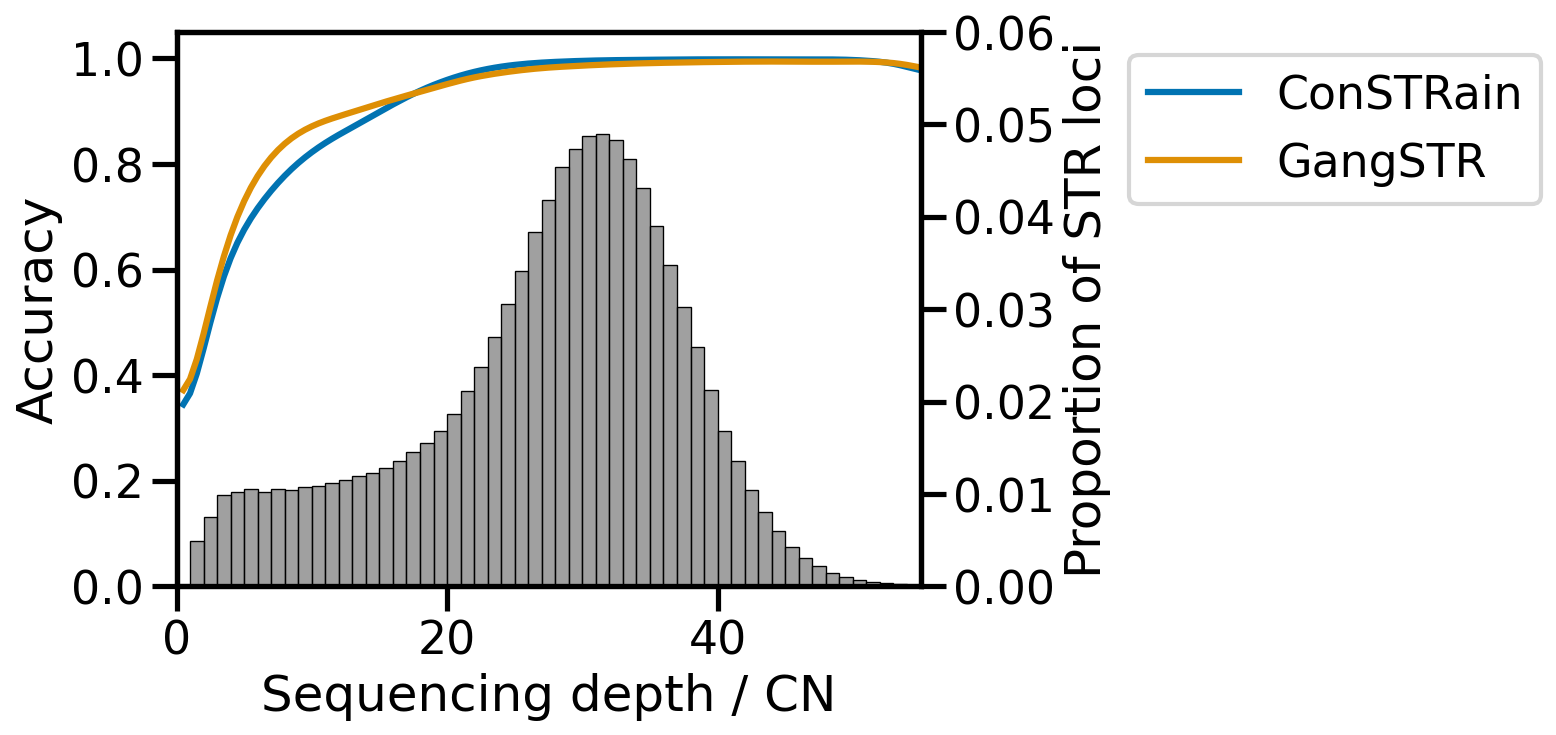

In [25]:
fig = plt.figure(dpi=150)

ax = sns.lineplot(
    df_plot_merge,
    x = "depth",
    y = "accuracy",
    hue = "method",
    palette="colorblind"
)

ax.set(
    # title = "GangSTR",
    xlabel = "Sequencing depth / CN",
    ylabel = "Accuracy",
    ylim = (0, 1.05),
    xlim = (0, 55)
)

ax2 = ax.twinx()
ax2 = sns.histplot(
    df_plot_density,
    x = "depth",
    discrete=True,
    stat="proportion",
    color="grey",
    ax=ax2,
)
ax2.set(
    ylabel="Proportion of STR loci",
    ylim=(0, 0.06),
)

ax.get_legend().set(bbox_to_anchor=(1.25, 1), loc="upper left", title="")

plt.show()

In [26]:
df_plot_merge_period = (
    df_plot_constrain_period.rename(columns = {"smooth": "ConSTRain"})
        .merge(
            df_plot_gangstr_period.rename(columns = {"smooth": "GangSTR"}), 
            on=["period", "depth"])[["period", "depth", "ConSTRain", "GangSTR"]]
        .melt(id_vars=["period", "depth"], var_name="method", value_name="accuracy"))

df_plot_merge_period

,period,depth,method,accuracy
0,1,1.0,ConSTRain,0.481596
1,1,1.5,ConSTRain,0.493136
2,1,2.0,ConSTRain,0.514320
3,1,2.5,ConSTRain,0.542007
4,1,3.0,ConSTRain,0.572777
...,...,...,...,...
1693,6,70.5,GangSTR,1.000000
1694,6,72.0,GangSTR,1.000000
1695,6,75.0,GangSTR,1.000000
1696,6,77.0,GangSTR,1.000000


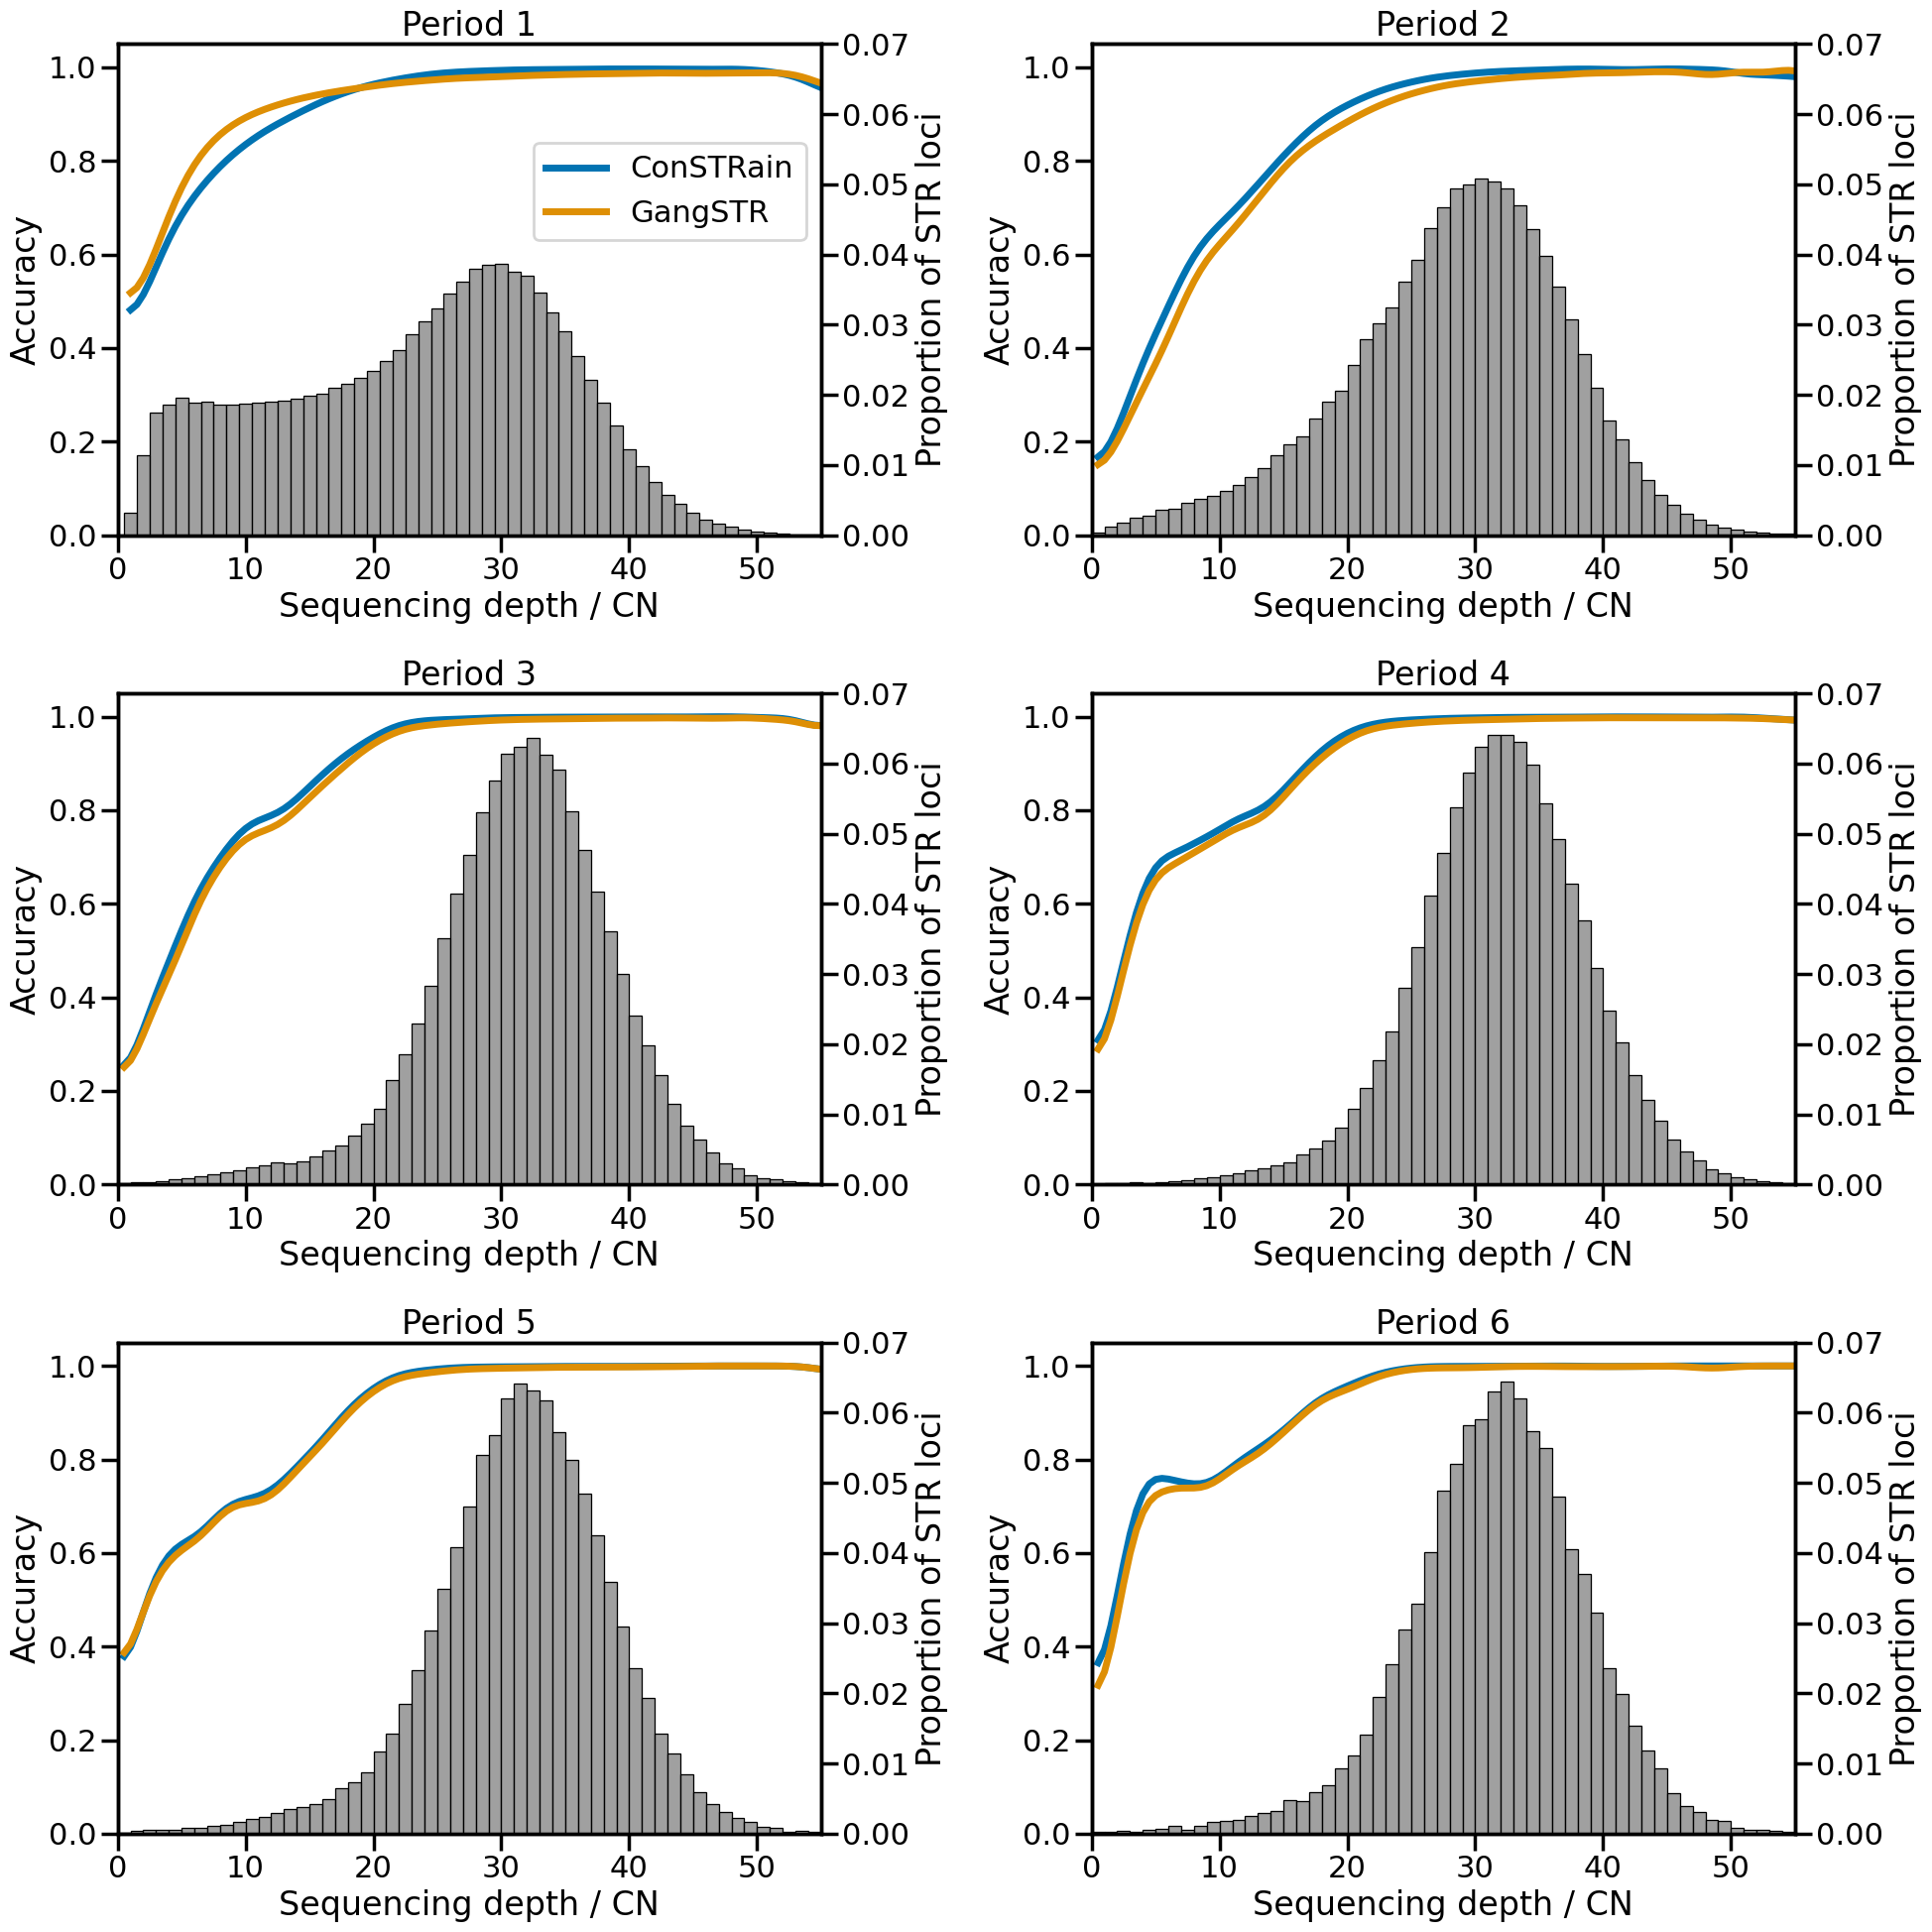

In [43]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

for period, ax in zip(range(1, 7), axes.ravel()):
    df_subplot = (df_plot_merge_period
                  .query(f"period == {period}"))

    add_legend = period == 1
    ax = sns.lineplot(
        df_subplot,
        x = "depth",
        y = "accuracy",
        hue = "method",
        palette="colorblind",
        linewidth=5,
        ax = ax,
        legend= add_legend
    )

    if add_legend:
        ax.get_legend().set(
            bbox_to_anchor=(1, 0.7), loc="center right", title=None)
    
    ax.set(
        title = f"Period {period}",
        xlabel = "Sequencing depth / CN",
        ylabel = "Accuracy",
        ylim = (0, 1.05),
        xlim = (0, 55)
    )
    
    ax2 = ax.twinx()
    ax2 = sns.histplot(
        df_plot_density.query(f"period == {period}"),
        x = "depth",
        discrete=True,
        stat="proportion",
        color="grey",
        ax=ax2,
    )
    
    ax2.set(
        ylabel="Proportion of STR loci",
        # ylim=(0, ax2.get_ylim()[1] + 0.01),
        ylim=(0, 0.07),
    )

plt.tight_layout()